In [1]:
import pandas as pd
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from catboost import CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.inspection import permutation_importance
from BorutaShap import BorutaShap
from sklearn import preprocessing
from boruta import BorutaPy
import xgboost
import eli5
from sklearn.metrics import r2_score
from lime import lime_tabular
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import linear_model
from SALib.plotting.bar import plot as barplot
import matplotlib.pylab as pl
import numpy as np
from SALib.plotting.bar import plot as barplot
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.metrics import mean_squared_error
from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from SALib.sample import morris
from SALib.test_functions import Ishigami
from SALib.plotting.bar import plot as barplot
from SALib import analyze as ann
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay



In [1]:
from IPython.display import Image
from preparing_model import *

In [2]:
import shap
shap.initjs()

In [3]:
def plot_interaction(symm_inter_sobol, names):
    pl.figure(figsize=(12,12))
    pl.imshow(np.abs(symm_inter_sobol))
    pl.yticks(range(symm_inter_sobol.shape[0]), names, rotation=50.4, horizontalalignment="right")
    pl.xticks(range(symm_inter_sobol.shape[0]), names, rotation=50.4, horizontalalignment="left")
    pl.gca().xaxis.tick_top()
    pl.show()

In [44]:
def prepare_plot_shap_interaction(shap_interaction_values):
    tmp = np.abs(shap_interaction_values).sum(0)
    for i in range(tmp.shape[0]):
        tmp[i,i] = 0
    inds = np.argsort(-tmp.sum(0))[:50]
    tmp2 = tmp[inds,:][:,inds]
    return tmp2, inds

In [30]:
def plot_basic_analysis(X_test, y_test, cb_regressor):
    r = permutation_importance(cb_regressor, X_test, y_test, n_repeats=100, random_state=0)
    # Ваши данные
    df1 = pd.DataFrame({"Compaund": X_test.columns, "amount": cb_regressor.feature_importances_})
    df2 = pd.DataFrame({"Compaund": X_test.columns, "amount": r.importances_mean})

    # Создаем фигуру и два подграфика
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Первый график
    sns.barplot(data=df1, y="Compaund", x="amount", orient='h', ax=axes[0])
    axes[0].set_title('Inner model feature importances')

    # Второй график
    sns.barplot(data=df2, y="Compaund", x="amount", orient='h', ax=axes[1])
    axes[1].set_title('Permutation importance')

    plt.tight_layout()
    plt.show()

In [8]:
def get_train_test(x_y_filaneme, target_name="cum_infections"):
    data = pd.read_csv(x_y_filaneme, sep=",")
    X = data.drop(target_name, axis=1)
    y = data[target_name]
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
def sobol_analyze(problem, y_filename):
    y_sobol = np.load(y_filename)
    return sobol.analyze(problem, y_sobol)

In [5]:
def morris_analyze(problem, x_filename, y_filename):
    y_morris = np.load(y_filename)
    params_morris = np.load(x_filename)
    return ann.morris.analyze(
        problem, params_morris, y_morris, 
        conf_level=0.95, print_to_console=True, num_levels=4)

In [6]:
def make_symm_inter_sobol(inter_sobol):
    res = np.copy(inter_sobol)
    res = np.nan_to_num(res, 0)
    res += np.transpose(res)
    return res

In [53]:
def select_features(pool_train, pool_test, columns,
                          algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    model = CatBoostRegressor(iterations=500)
    summary = model.select_features(
        pool_train,
        eval_set=pool_test,
        features_for_select=list(range(len(columns))),
        num_features_to_select=5,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

## Epidimiological parameters

Определяем: 
* переменные для анализа
* границы значений

In [38]:
names_epid = ['rel_beta',
                'rel_symp_prob',
                'rel_severe_prob',
                'rel_crit_prob',
                'rel_death_prob',
                'dur_exp2inf',
                'dur_inf2sym',
                'dur_sym2sev',
                'dur_sev2crit',
                'dur_asym2rec',
                'dur_mild2rec',
                'dur_sev2rec',
                'dur_crit2rec',
                'dur_crit2die',
                'oral_microbiota_percent',
                'oral_microbiota_factor',
                'n_imports',
                'indices_starting_months',
                'indices_weather',
                'indices_rel_sus_type']
param2ind = dict(zip(names_epid, range(len(names_epid))))
problem_epid = {
    'num_vars': len(names_epid),
    'names': names_epid,
    'bounds': [[1.3194024973905982e-05, 1.9999425593941065],
            [0.0001059037659971, 1.99987452255794],
            [0.0002294889944518, 1.9999690385440527],
            [1.1662541377299718e-05, 1.999988850911703],
            [0.0003941551701103, 1.999698598745013],
            [2.000602033966775, 5.999937611927544],
            [9.033236261313248e-05, 1.99996917989662],
            [2.000555057201062, 9.999799633851948],
            [0.0001424376024165, 2.9993645217130664],
            [4.000210396272597, 11.999356371721072],
            [4.0002485424543, 11.998532442496924],
            [10.001949044431957, 29.999978630136265],
            [10.000866868808028, 29.99786878107664],
            [6.000592711534851, 14.99916146707454],
            [5.28217691269095e-05, 0.9999790775007206],
            [0.0001383684747588, 0.9999580139962424],
            [1, 999],
            [0, 3],
            [0, 2],
            [0, 8]]}

### Statistical analysis

#### Morris method

In [10]:
Si_epid_morris = morris_analyze(
    problem=problem_epid,
    y_filename="morris_1_10k.npy",
    x_filename="../param_values_epid_10k.npy"
)

                                  mu      mu_star        sigma  mu_star_conf
rel_beta                 19884.42750  19884.42750  5987.715667    790.762086
rel_symp_prob             1435.66500   3880.36500  5856.683261    598.667322
rel_severe_prob            551.52375    709.31625  1384.253250    219.856026
rel_crit_prob              125.59125    347.33625  1059.292117    138.137813
rel_death_prob            -114.73500    280.95000   907.006795    119.833584
dur_exp2inf                323.10000    957.43500  1834.107180    222.516568
dur_inf2sym               1168.45125   1300.25625  2201.677508    292.135676
dur_sym2sev                138.15375    250.58625   835.711050    107.380518
dur_sev2crit               -15.02250    250.89000  1250.509134    176.742152
dur_asym2rec              5750.61375   5755.51125  6424.376083    923.399363
dur_mild2rec              3630.22875   3655.78875  4509.350357    630.825144
dur_sev2rec                297.05250    407.64750   992.796156    136.694278

1. **$\mu$**:
   - Это среднее значение изменений выходной переменной, когда входной параметр изменяется на определённый шаг. По сути, $\mu$ оценивает среднее влияние параметра на модель. Чем больше значение $\mu$, тем больше влияние данного параметра.

2. **$\mu^*$**:
   - Это модифицированное среднее значение изменений, которое учитывает абсолютные значения изменений. $\mu^*$ отличается от $\mu$ тем, что игнорирует направление изменений и фокусируется только на величине влияния. Это позволяет учитывать как положительное, так и отрицательное влияние параметра на модель. Таким образом, $\mu^*$ предоставляет информацию о среднем абсолютном эффекте параметра.

3. **$\sigma$**:
   - Это стандартное отклонение изменений выходной переменной при варьировании входного параметра. $\sigma$ показывает, насколько стабильно или нестабильно параметр влияет на модель. Высокое значение $\sigma$ указывает на значительную вариабельность влияния параметра, что может свидетельствовать о наличии взаимодействий с другими параметрами или нелинейных эффектов.

<AxesSubplot: >

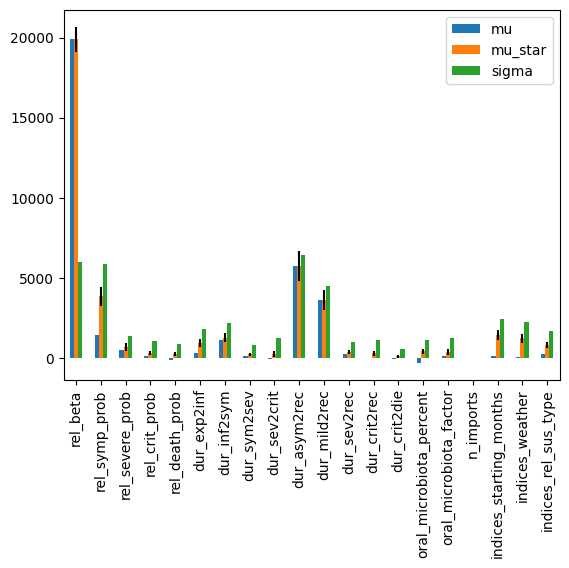

In [11]:
barplot(Si_epid_morris.to_df())

#### Sobol method

##### One factor

In [13]:
Si_epid_sobol = sobol_analyze(
    problem=problem_epid, 
    y_filename='sobol_100k_1.npy'
)

<AxesSubplot: >

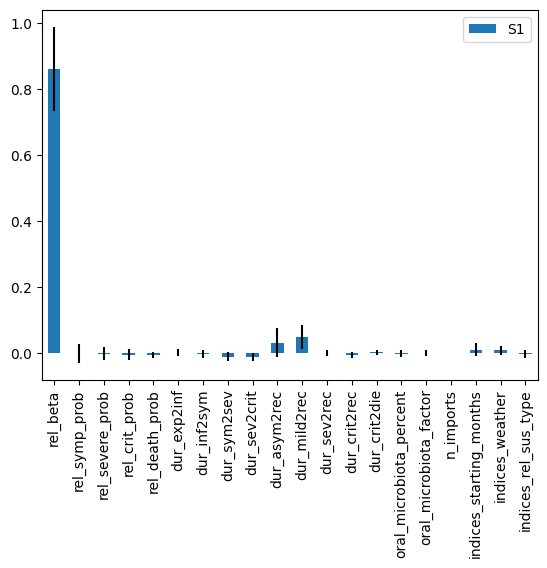

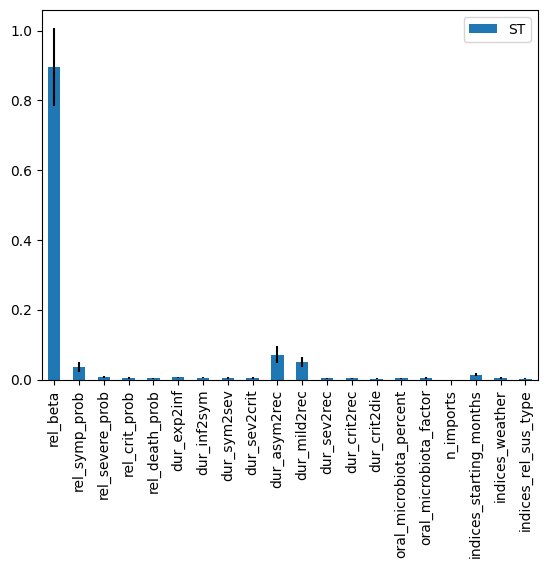

In [14]:
total, first, second = Si_epid_sobol.to_df()
barplot(first)
barplot(total)


##### Interaction factors

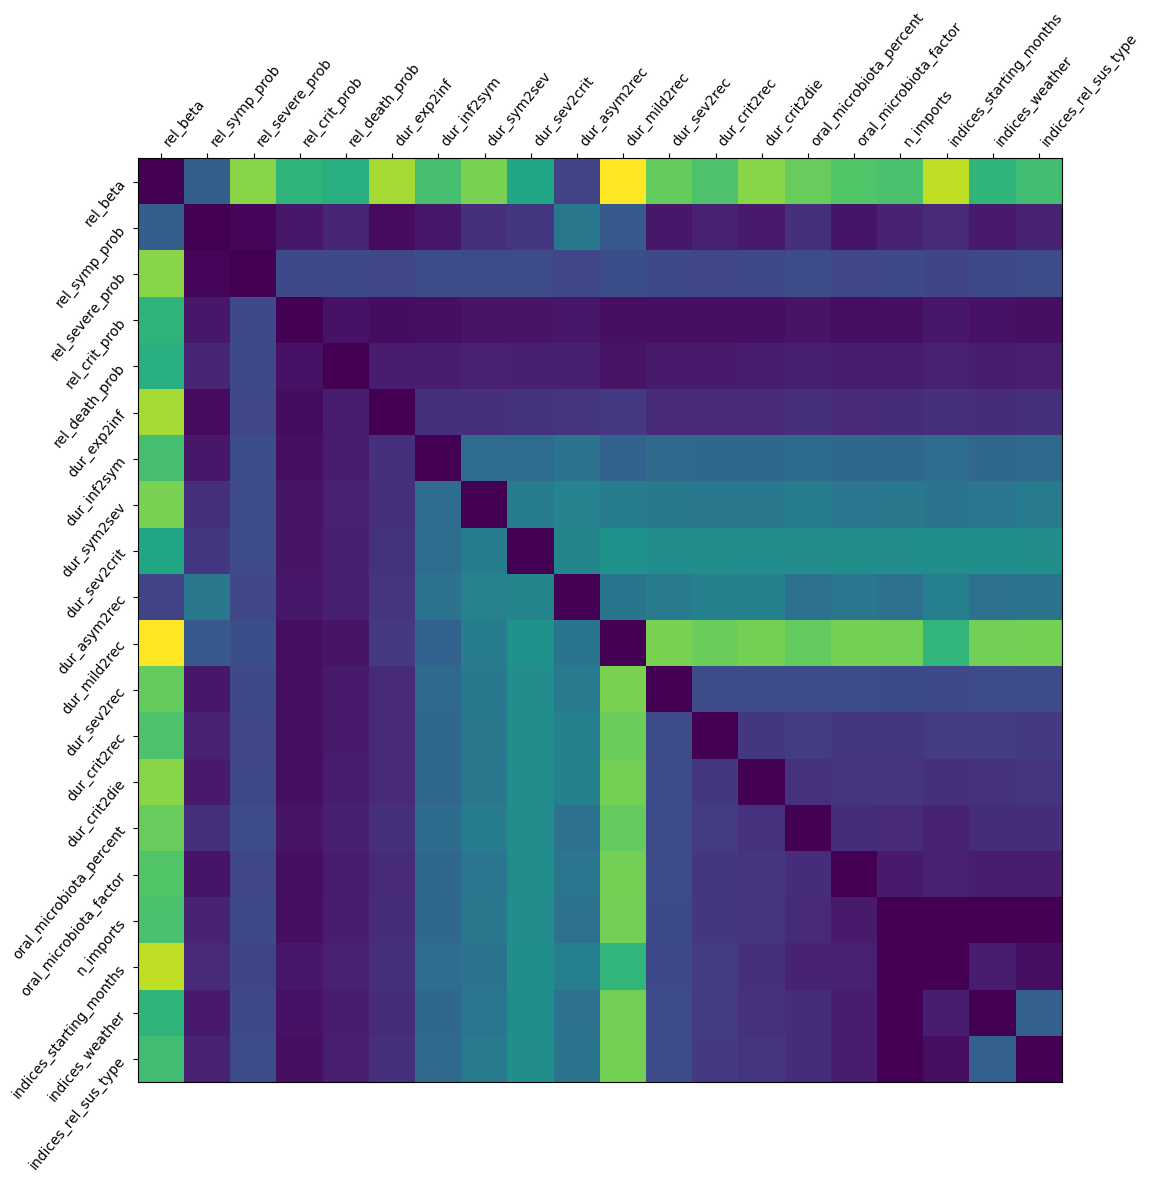

In [23]:
symm_inter_sobol_epid = make_symm_inter_sobol(Si_epid_sobol['S2'])
plot_interaction(symm_inter_sobol_epid, names_epid)

### Machine learning approach

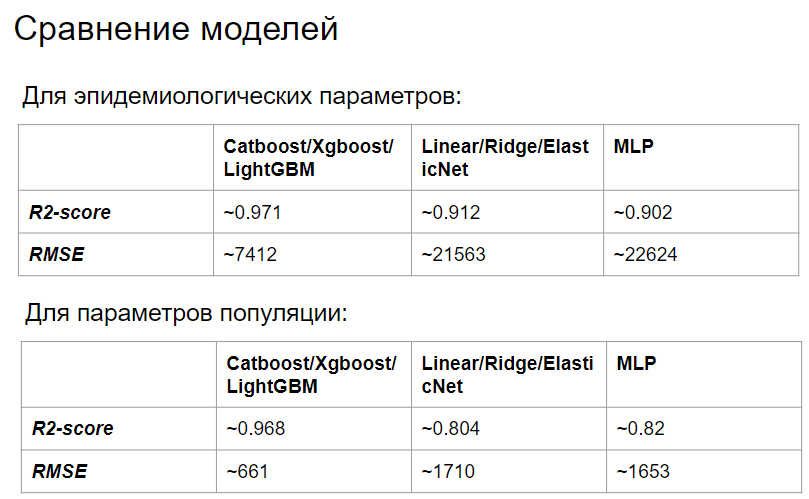

In [2]:
Image(filename='comparing_scores_update.PNG')

#### Preparing data and build models

In [10]:
X_train, X_test, y_train, y_test = get_train_test('all_pars_virus_100k.csv')

In [11]:
X_train.head(5)

rel_beta  rel_symp_prob  rel_severe_prob  rel_crit_prob  \
8647   0.636386       0.784878         0.644312       0.215390   
1799   1.812908       0.485365         0.641656       1.494170   
10325  0.679430       1.258352         1.751333       0.659986   
14315  0.968524       1.877819         1.527827       1.501335   
12163  1.056385       0.719136         1.786161       1.200738   

       rel_death_prob  dur_exp2inf  dur_inf2sym  dur_sym2sev  dur_sev2crit  \
8647         0.423604     4.364349     1.377433     4.903987      1.059433   
1799         1.428212     4.956465     0.280008     6.080170      0.110974   
10325        0.665774     5.172162     1.162010     6.217835      2.460496   
14315        1.430574     3.832257     0.071286     8.645232      1.961803   
12163        1.763937     4.847674     0.842615     9.378702      2.029474   

       dur_asym2rec  dur_mild2rec  dur_sev2rec  dur_crit2rec  dur_crit2die  \
8647       5.483758      4.942288    18.655662     12.327222     13.465180   
1799       5.086817     11.548534    26.652992     17.676364     11.421804   
10325      5.215867      6.524350    11.246417     22.896728     10.817869   
14315      6.880168      6.968736    28.202948     16.141511      6.579530   
12163      9.917986     10.681829    19.088848     24.479064     14.837484   

       oral_microbiota_percent  oral_microbiota_factor  n_imports  \
8647                  0.880492                0.817354        724   
1799                  0.400918                0.920166         35   
10325                 0.533361                0.856717         87   
14315                 0.374338                0.333762        312   
12163                 0.593154                0.843301        136   

       indices_starting_months  indices_weather  indices_rel_sus_type  
8647                         1                2                     4  
1799                         2                0                     6  
10325                        2                1                     0  
14315                        3                1                     0  
12163                        0                2                     8

In [12]:
cb_regressor = fit_un_model(X_train, y_train, cat_features=['indices_starting_months', 'indices_weather', 'indices_rel_sus_type'])

##### Check model

In [17]:
validatation_model(cb_regressor, X_test, y_test)

R-squared score: 0.9879631737453043


#### Analyse of models

##### Base analysis

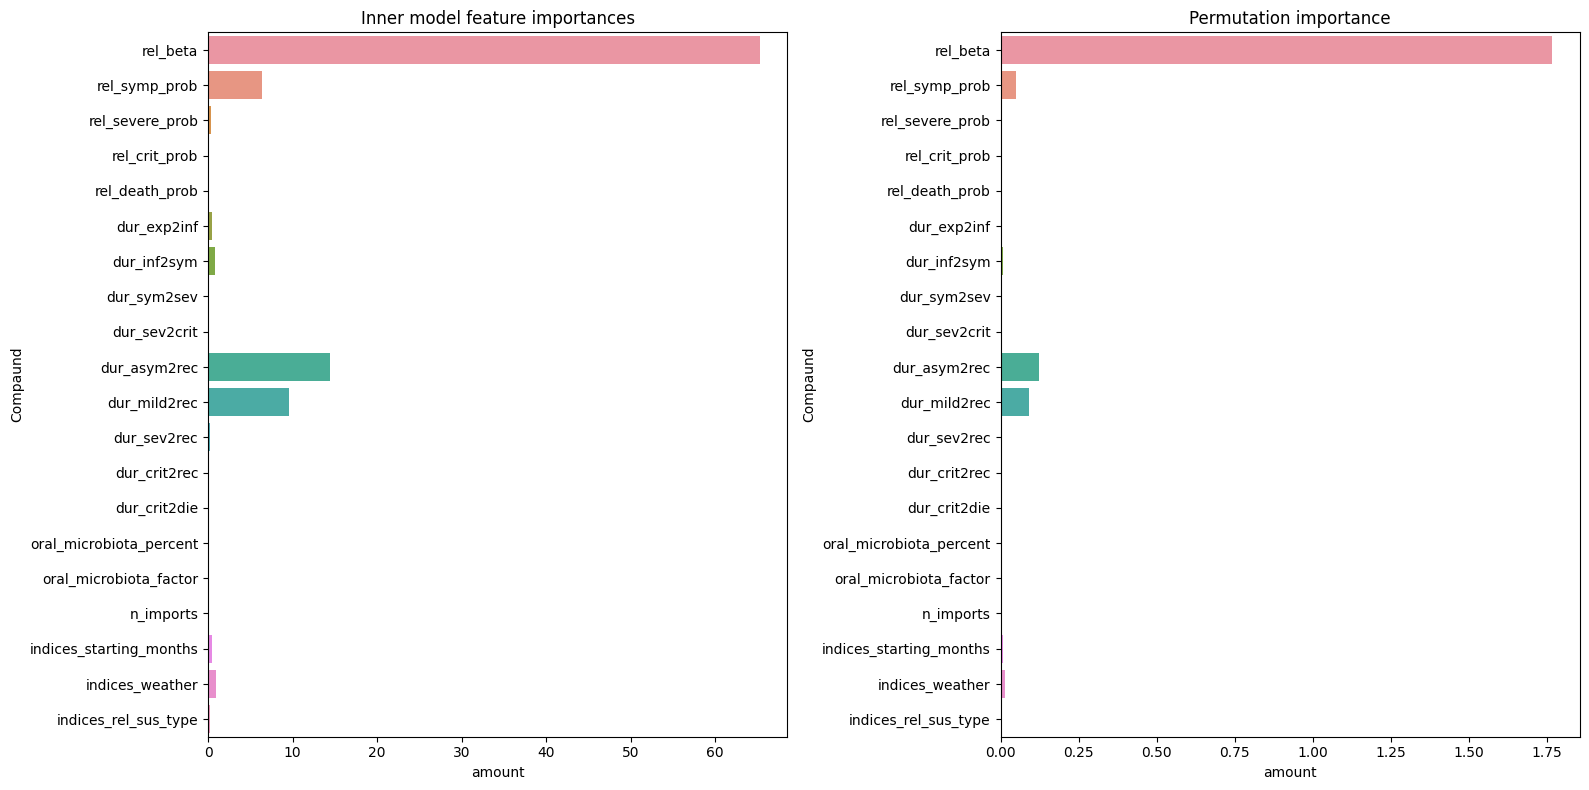

In [31]:
plot_basic_analysis(X_test, y_test, cb_regressor)

##### Shap analysis

Calc *shap values*

In [32]:
shap_values = cb_regressor.get_feature_importance(Pool(X_test, y_test, cat_features=["indices_starting_months", "indices_weather", "indices_rel_sus_type"]), type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

Plot *shap values*

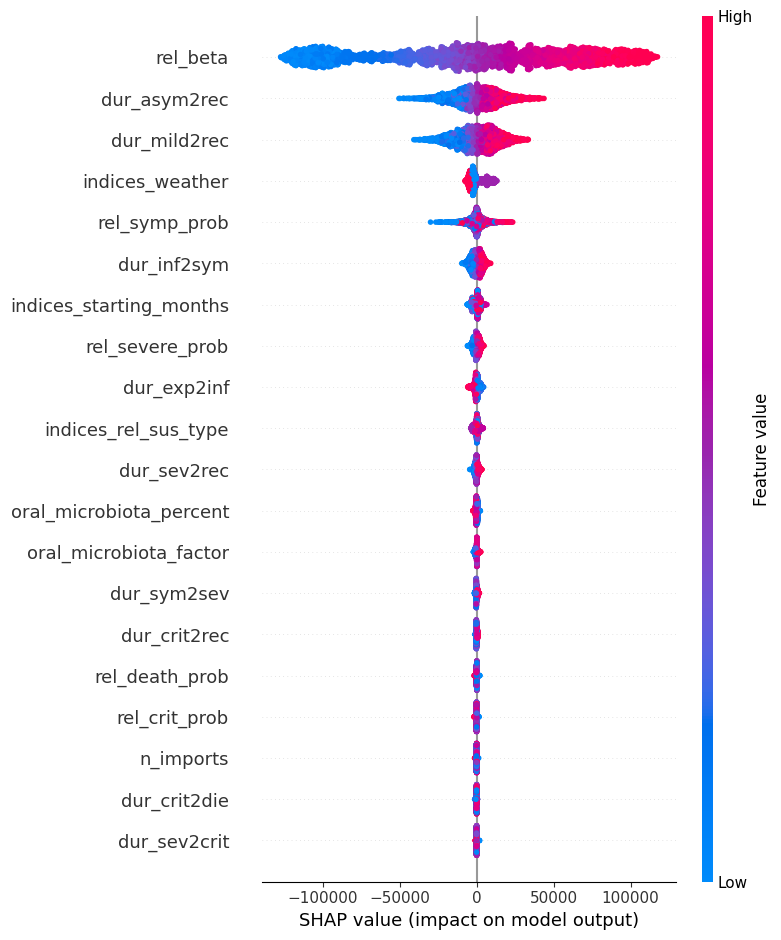

In [34]:
shap.summary_plot(shap_values, X_test)

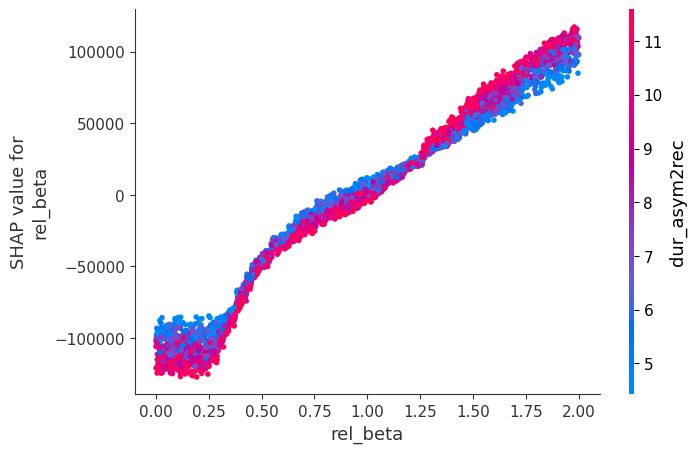

In [52]:
shap.dependence_plot("rel_beta", shap_values, X_test)

Calc *shap interaction values*

In [35]:
shap_interaction_values = cb_regressor.get_feature_importance(Pool(X_test.iloc[:2000,:], y_test[:2000], cat_features=["indices_starting_months", "indices_weather", "indices_rel_sus_type"]), type='ShapInteractionValues')
shap_interaction_values = shap_interaction_values[:, :shap_interaction_values.shape[-1]-1, :shap_interaction_values.shape[-1]-1]

Plot *shap interaction values*

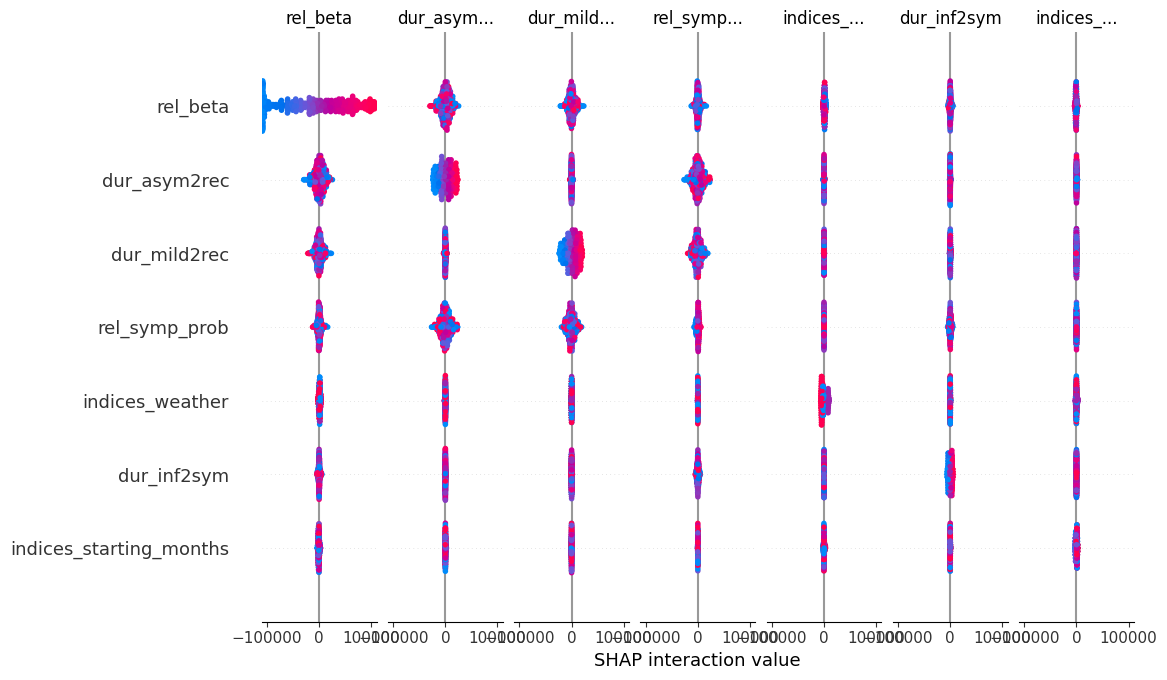

In [36]:
shap.summary_plot(shap_interaction_values[:500], X_test.iloc[:500,:])

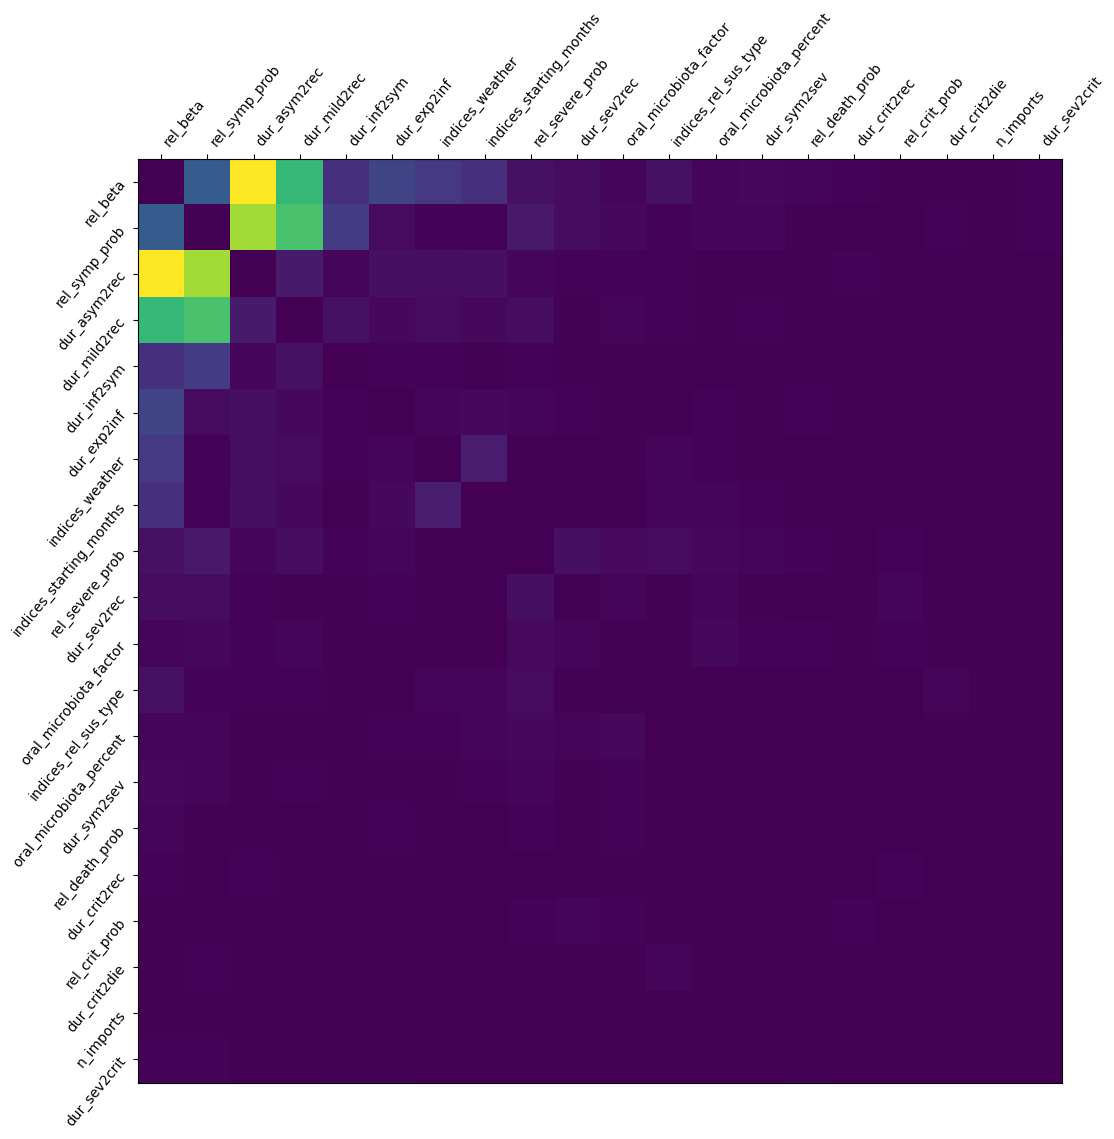

In [50]:
siv_p, names_inds = prepare_plot_shap_interaction(shap_interaction_values)
plot_interaction(siv_p, np.array(names_epid)[names_inds])

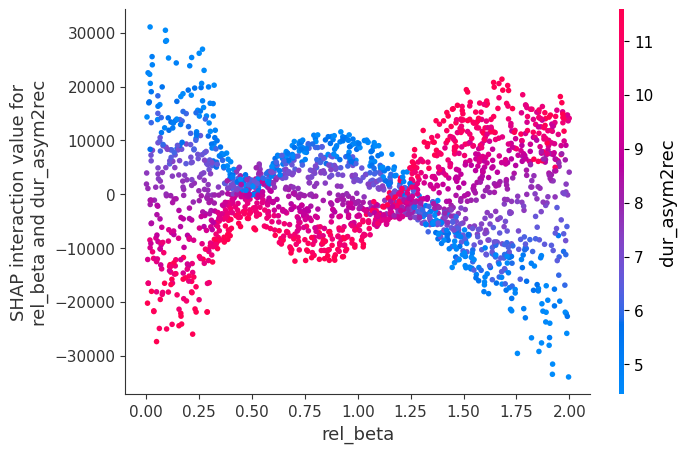

In [51]:
shap.dependence_plot(("rel_beta", "dur_asym2rec"),
    shap_interaction_values, X_test[:][:2000]
)

##### Selecting features

*Recursive feature elimination*

In [55]:
shap_summary = select_features(
    pool_train=Pool(X_train, y_train, cat_features=["indices_starting_months", "indices_weather", "indices_rel_sus_type"]), 
    pool_test=Pool(X_test, y_test, cat_features=["indices_starting_months", "indices_weather", "indices_rel_sus_type"]), 
    columns=X_test.columns,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['rel_beta', 'rel_symp_prob', 'dur_asym2rec', 'dur_mild2rec', 'indices_weather']


*Boruta*

In [57]:
#Feature_Selector = BorutaShap(model=cb_regressor,
#                              importance_measure='shap',
#                              classification=False)
#
#Feature_Selector.fit(X=X_train, y=y_train, n_trials=100, random_state=0)

## Population parameters

Определяем: 
* переменные для анализа
* границы значений

In [59]:
names_synth = [
        'enrollment_rates_by_age',
        'employment_rates_by_age',
        'school_size_distribution_by_pk',
        'school_size_distribution_by_es',
        'school_size_distribution_by_uv',
        'household_size_distribution',
        'h_contact_matrix',
        'workplace_size_counts_by_num_personnel',
        'w_contact_matrix',
        'average_student_teacher_ratio',
        'average_class_size',
        'average_teacher_teacher_degree',
        'average_student_all_staff_ratio',
        'average_additional_staff_degree']
problem_synth = {
    'num_vars': len(names_synth),
    'names': names_synth,
    'bounds': [
    [0, 6],
    [0, 6],
    [0, 6],
    [0, 6],
    [0, 6],
    [0, 6],
    [0, 11],
    [0, 6],
    [0, 11],
    [10, 29],
    [0, 15],
    [0, 9],
    [1, 10],
    [5, 34]]
}

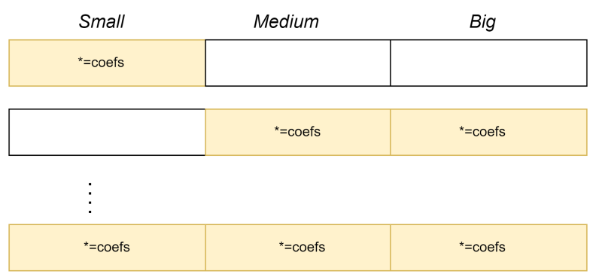

In [87]:
Image(filename='data_organiztion_dist.PNG')

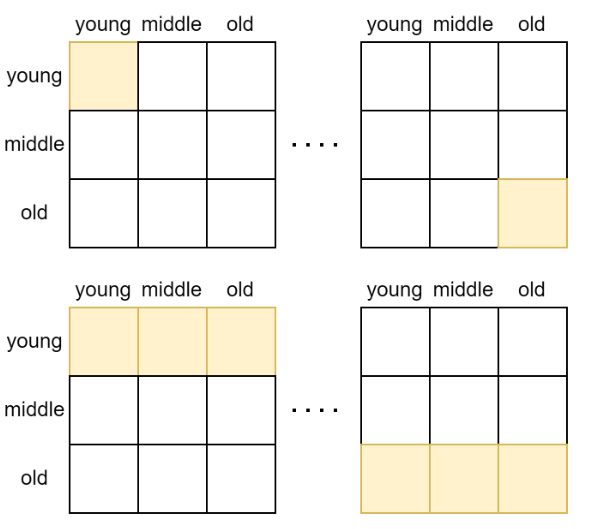

In [88]:
Image(filename='data_organiztion_matrix.PNG')

### Statistical analysis

#### Morris method

In [60]:
Si_synth_morris = morris_analyze(
    problem=problem_synth,
    y_filename="y_last_morris_2_100k.npy",
    x_filename="../params_last_morris_2.npy"
)

                                                mu     mu_star        sigma  \
enrollment_rates_by_age                 2198.14125  2311.03125  3956.524296   
employment_rates_by_age                 2207.92125  3403.28625  3510.687739   
school_size_distribution_by_pk            19.20375   902.38125  1187.157386   
school_size_distribution_by_es            47.76000  1023.82500  1326.478373   
school_size_distribution_by_uv           -95.29500   827.42250  1179.012044   
household_size_distribution             -146.94000  1069.74750  1300.953066   
h_contact_matrix                          30.80250   441.87750   794.633116   
workplace_size_counts_by_num_personnel   -34.56375  1055.16375  1389.893232   
w_contact_matrix                         -24.16125   457.58625   598.248610   
average_student_teacher_ratio           3019.96875  5263.98375  6188.300032   
average_class_size                      4768.47375  4768.47375  2160.697802   
average_teacher_teacher_degree           213.31500  

<AxesSubplot: >

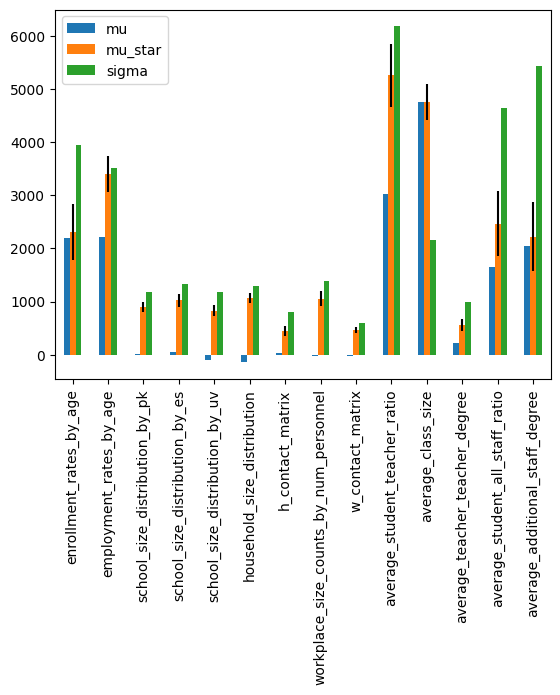

In [61]:
barplot(Si_synth_morris.to_df())

#### Sobol method

##### One factor

In [62]:
Si_synth_sobol = sobol_analyze(
    problem=problem_synth, 
    y_filename='y_last_sobol_2_100k.npy'
)

<AxesSubplot: >

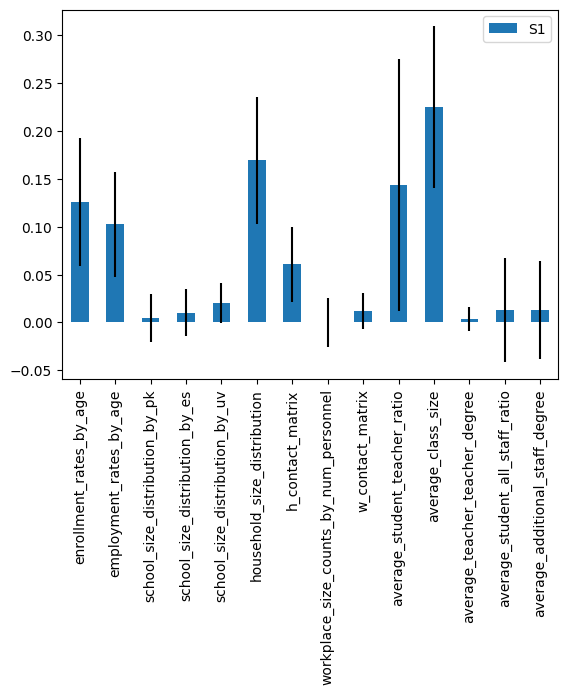

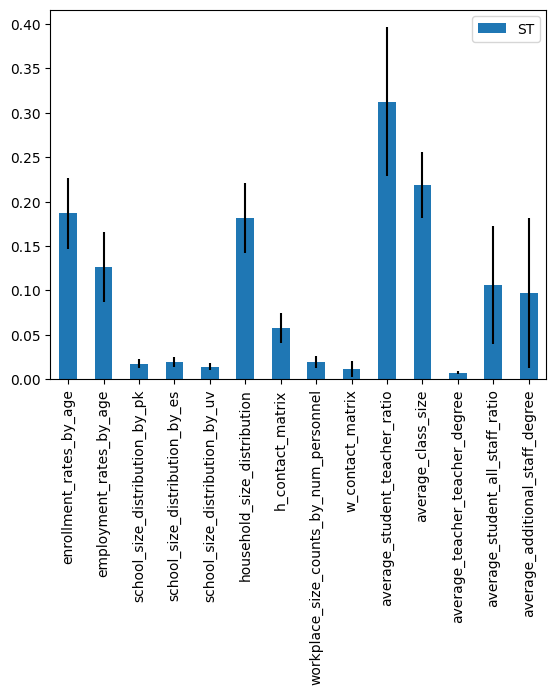

In [63]:
total, first, second = Si_synth_sobol.to_df()
barplot(first)
barplot(total)

##### Interaction factors

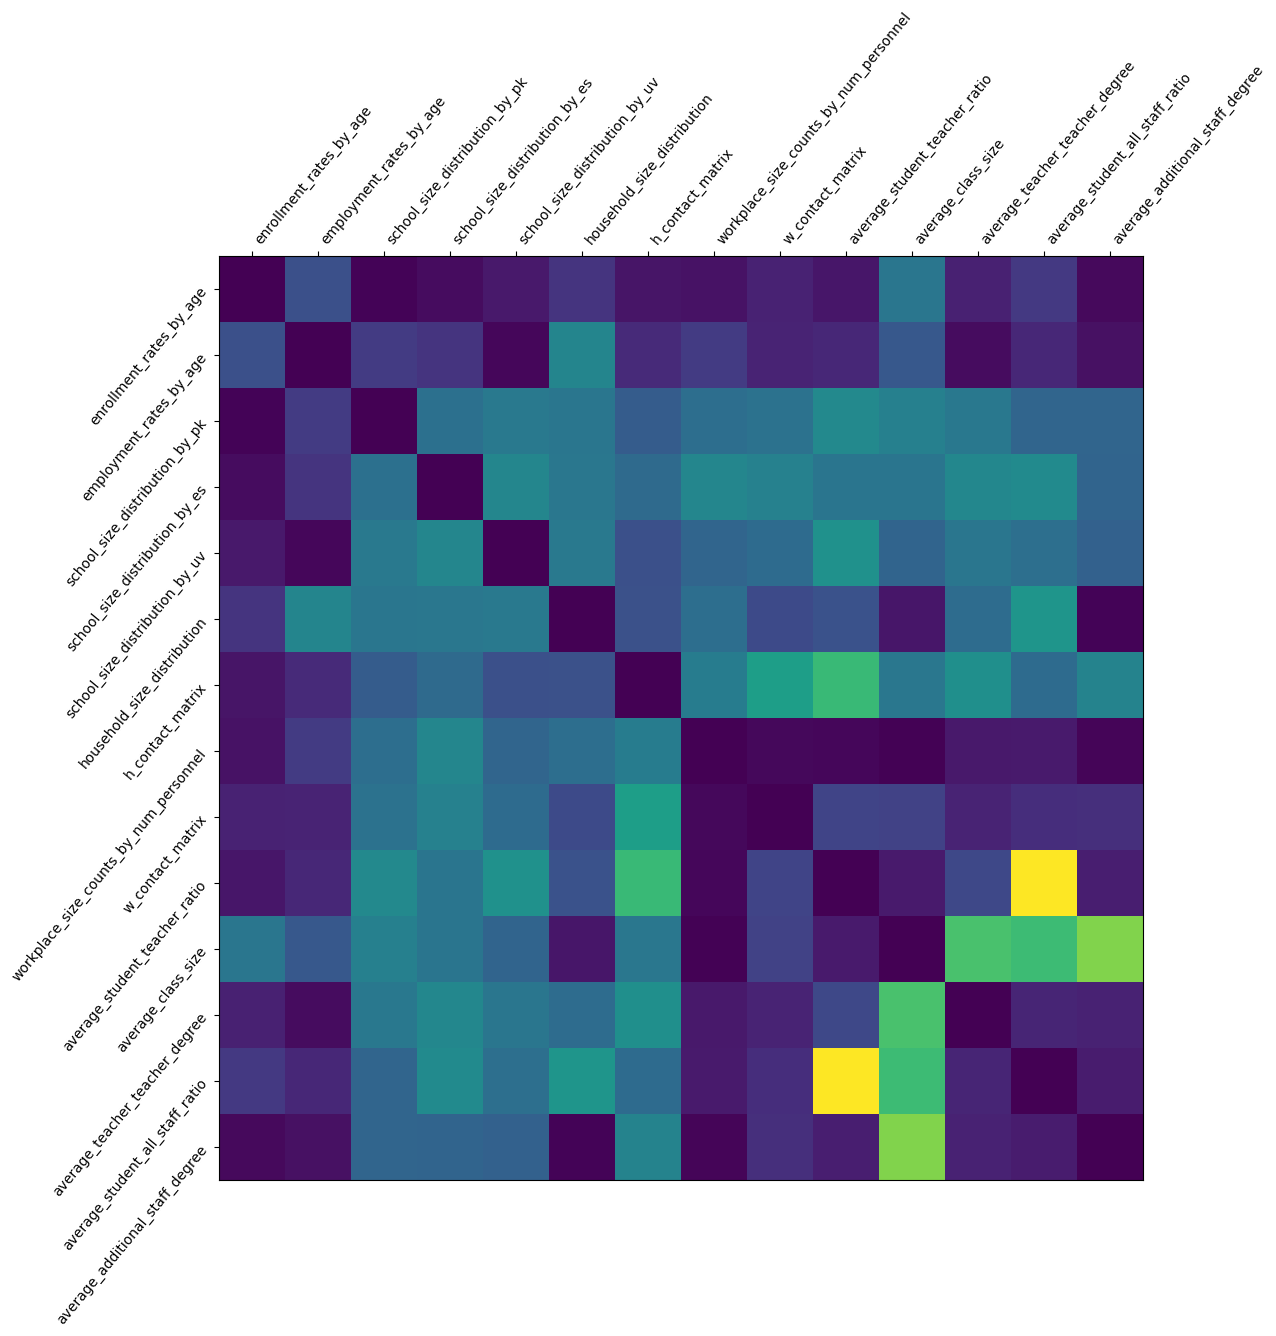

In [64]:
symm_inter_sobol_synth = make_symm_inter_sobol(Si_synth_sobol['S2'])
plot_interaction(symm_inter_sobol_synth, names_synth)

### Machine learning approach

#### Preparing data and build models

In [66]:
cat_features_synth = [
    'employment_rates_by_age',
    'enrollment_rates_by_age',
    'h_contact_matrix',
    'w_contact_matrix',
    'school_size_distribution_by_es',
    'school_size_distribution_by_pk',
    'school_size_distribution_by_uv',
    'household_size_distribution',
    'workplace_size_counts_by_num_personnel'
]
X_train, X_test, y_train, y_test = make_dataset_from_sobol_morris(
    x_filename_sobol="../params_last_sobol_2.npy", y_filename_sobol='y_last_sobol_2_100k.npy',        
    x_filename_morris="../params_last_morris_2.npy", y_filename_morris='y_last_morris_2_100k.npy',
    all_names=names_synth, cat_features=cat_features_synth     
)

In [67]:
X_train.head(5)

enrollment_rates_by_age  employment_rates_by_age  \
1034                        4                        2   
6929                        0                        5   
8510                        6                        0   
4969                        3                        3   
906                         3                        2   

      school_size_distribution_by_pk  school_size_distribution_by_es  \
1034                               2                               3   
6929                               0                               3   
8510                               6                               6   
4969                               4                               0   
906                                4                               1   

      school_size_distribution_by_uv  household_size_distribution  \
1034                               0                            1   
6929                               2                            5   
8510                               0                            2   
4969                               5                            4   
906                                4                            2   

      h_contact_matrix  workplace_size_counts_by_num_personnel  \
1034                 9                                       1   
6929                 6                                       0   
8510                 3                                       4   
4969                 9                                       3   
906                  5                                       1   

      w_contact_matrix  average_student_teacher_ratio  average_class_size  \
1034                 5                      22.208984           12.216797   
6929                 6                      14.564453           14.501953   
8510                 3                      16.333333           15.000000   
4969                 2                      22.431641           14.853516   
906                  9                      18.349609           14.794922   

      average_teacher_teacher_degree  average_student_all_staff_ratio  \
1034                        7.154297                         1.298828   
6929                        6.556641                         4.357422   
8510                        6.000000                         4.000000   
4969                        1.283203                         2.177734   
906                         1.388672                         3.408203   

      average_additional_staff_degree  
1034                         5.849609  
6929                        15.705078  
8510                         5.000000  
4969                        14.119141  
906                         31.564453

In [68]:
cb_regressor = fit_un_model(X_train, y_train, cat_features=cat_features_synth)

##### Check model

In [69]:
validatation_model(cb_regressor, X_test, y_test)

R-squared score: 0.9691892363787538


#### Analyse of models

Base analyse

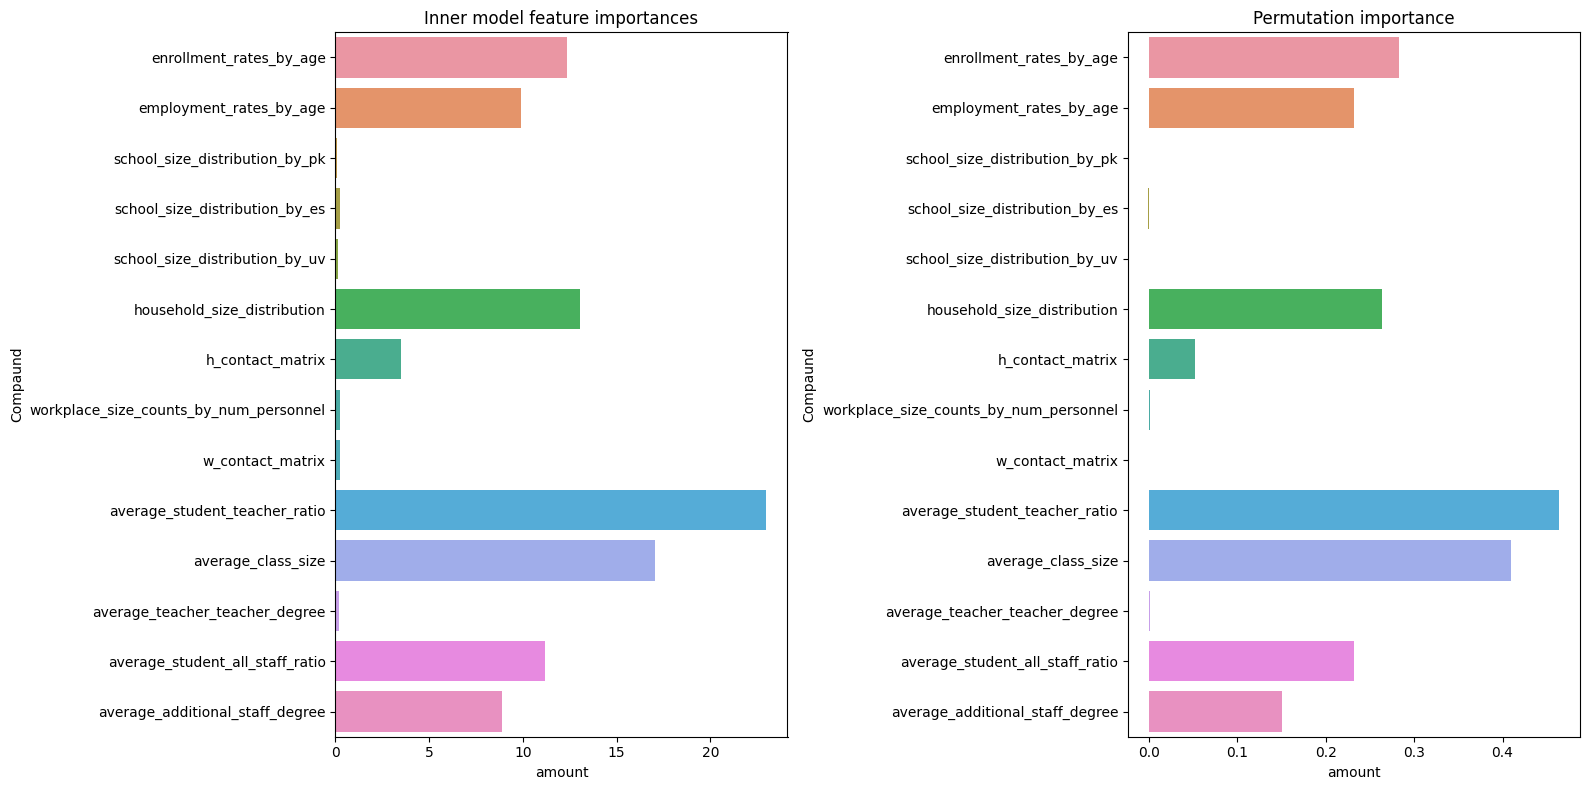

In [70]:
plot_basic_analysis(X_test, y_test, cb_regressor)

##### Shap analyse

Calc *shap values*

In [71]:
shap_values = cb_regressor.get_feature_importance(Pool(X_test, y_test, cat_features=cat_features_synth), type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

Plot *shap values*

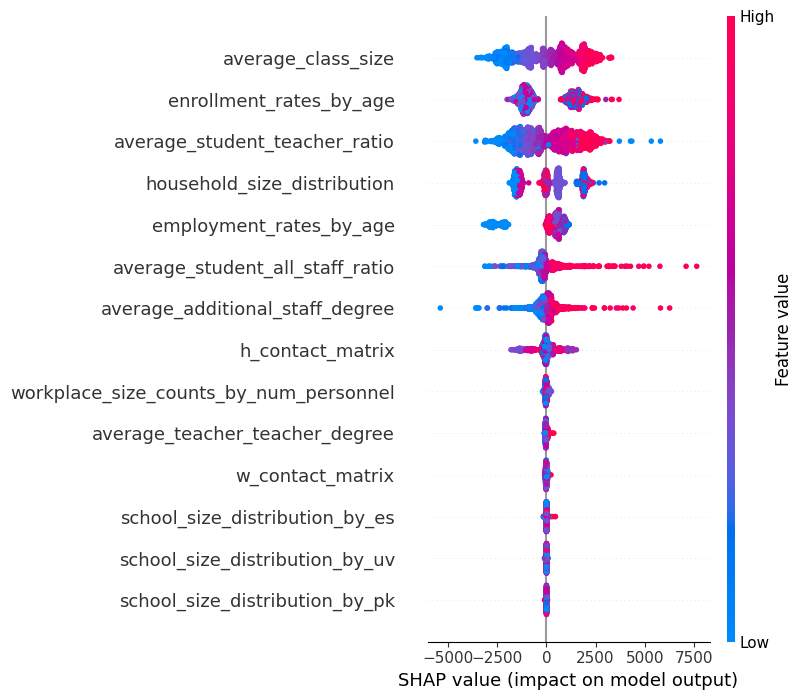

In [72]:
shap.summary_plot(shap_values, X_test)

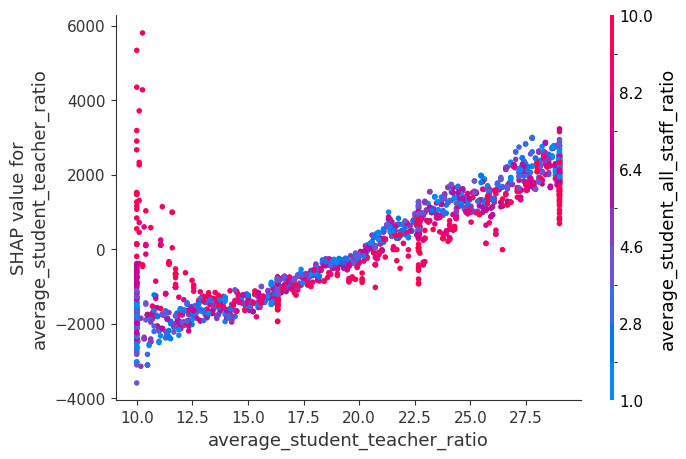

In [76]:
shap.dependence_plot("average_student_teacher_ratio", shap_values, X_test)

Calc *shap interaction values*

In [77]:
shap_interaction_values = cb_regressor.get_feature_importance(Pool(X_test.iloc[:2000,:], y_test[:2000], cat_features=cat_features_synth), type='ShapInteractionValues')
shap_interaction_values = shap_interaction_values[:, :shap_interaction_values.shape[-1]-1, :shap_interaction_values.shape[-1]-1]

Plot *shap interaction values*

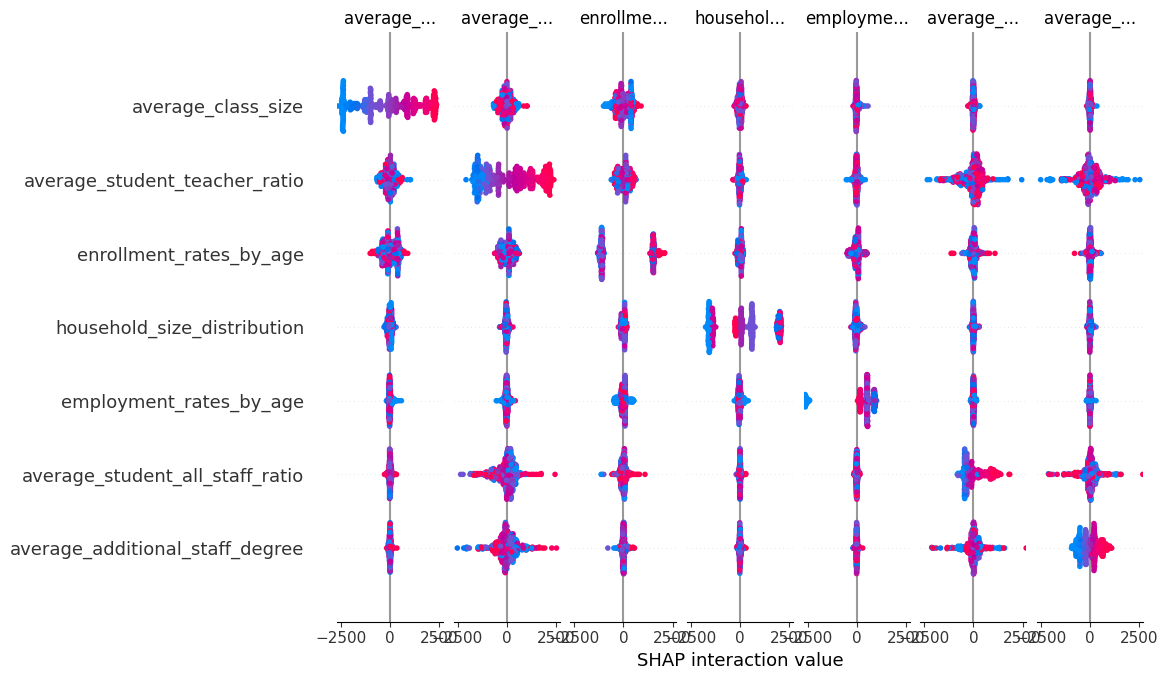

In [78]:
shap.summary_plot(shap_interaction_values[:500], X_test.iloc[:500,:])

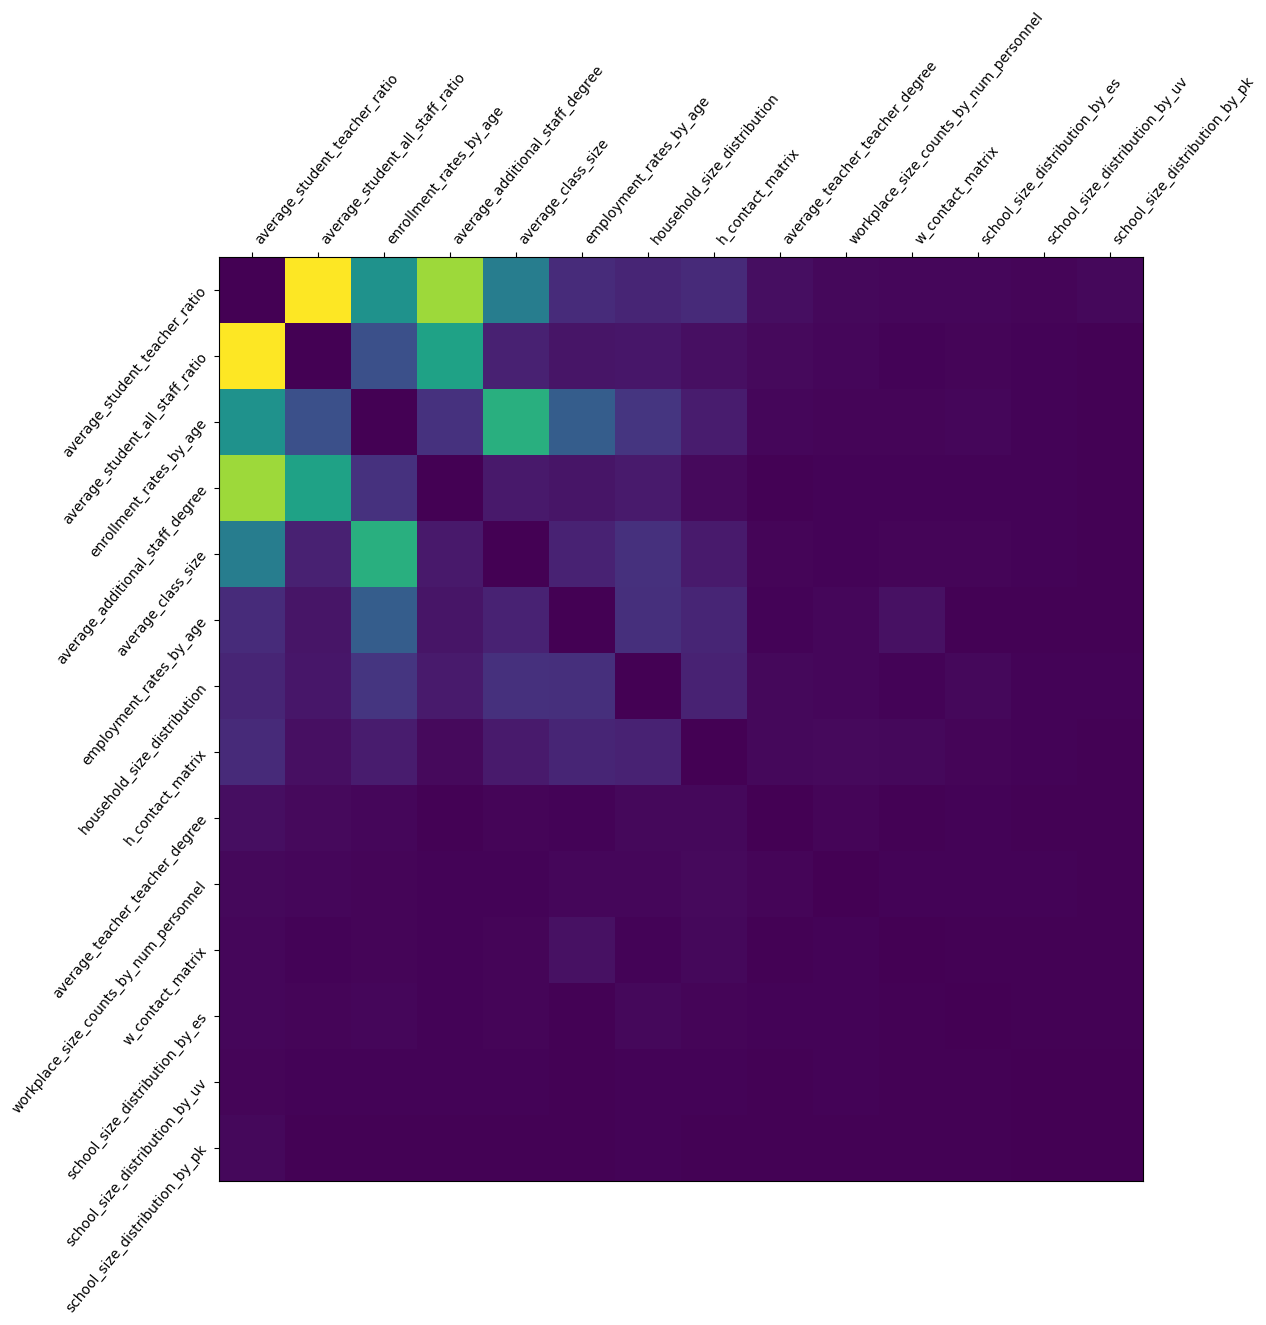

In [79]:
siv_p, names_inds = prepare_plot_shap_interaction(shap_interaction_values)
plot_interaction(siv_p, np.array(names_synth)[names_inds])

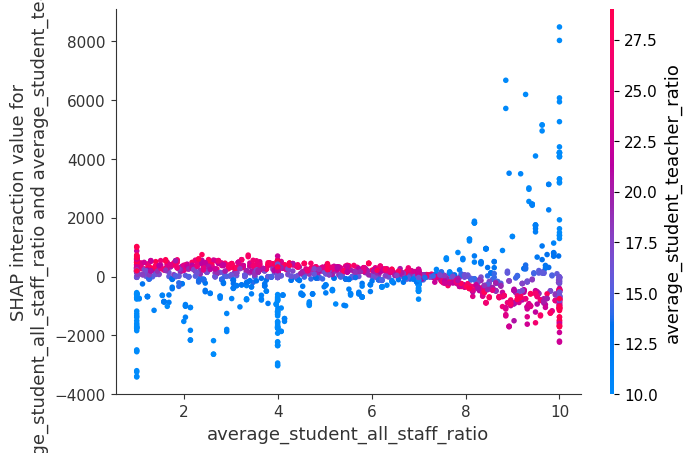

In [80]:
shap.dependence_plot(("average_student_all_staff_ratio", "average_student_teacher_ratio"),
    shap_interaction_values, X_test[:][:2000]
)

#### Selecting features

In [81]:
shap_summary = select_features(
    pool_train=Pool(X_train, y_train, cat_features=cat_features_synth), 
    pool_test=Pool(X_test, y_test, cat_features=cat_features_synth), 
    columns=X_test.columns,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['enrollment_rates_by_age', 'employment_rates_by_age', 'household_size_distribution', 'average_student_teacher_ratio', 'average_class_size']


## Top features

                                        mu      mu_star         sigma  \
rel_beta                       177678.3675  177678.3675  45755.352662   
rel_symp_prob                    7040.3550   33197.3700  52687.450636   
dur_asym2rec                    35103.1125   35111.1375  45349.791226   
dur_mild2rec                    40872.3225   41116.5525  41932.629243   
enrollment_rates_by_age          4493.4675    4878.2025   9934.224227   
employment_rates_by_age          2877.7350    4688.7300   6790.274174   
household_size_distribution      -948.8250    2281.2750   4182.007773   
average_student_teacher_ratio    8692.2450    9089.4750  10659.166764   
average_class_size               7631.6625    8211.6825   9616.993471   

                               mu_star_conf  
rel_beta                        8678.622137  
rel_symp_prob                   8256.084642  
dur_asym2rec                    8633.518147  
dur_mild2rec                    8274.186158  
enrollment_rates_by_age         1692.77

<AxesSubplot: >

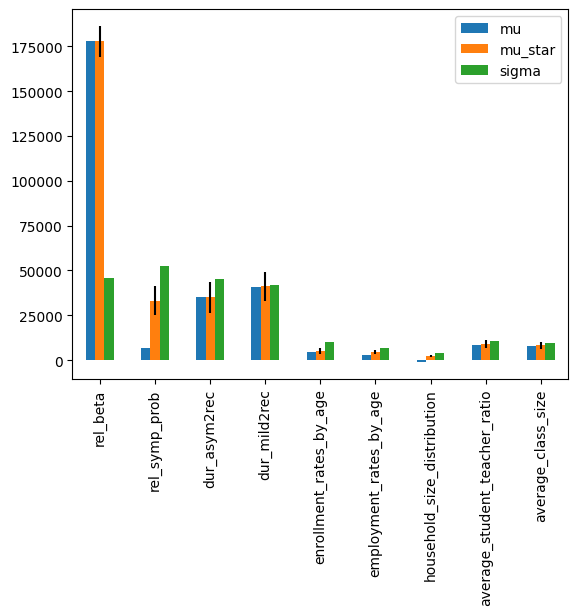

In [ ]:
#y_multi = np.load("y_last_morris_3_100k.npy")
#params_multi = np.load("../param_values_last_morris_3.npy")
#Si_multi = ann.morris.analyze(problem_multi, params_multi, y_multi, conf_level=0.95,
#                    print_to_console=True, num_levels=4)
#barplot(Si_multi.to_df())

<AxesSubplot: >

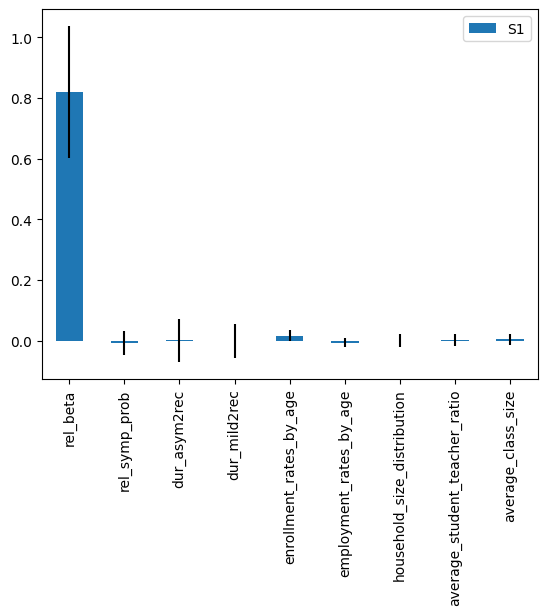

In [ ]:
#barplot(first)

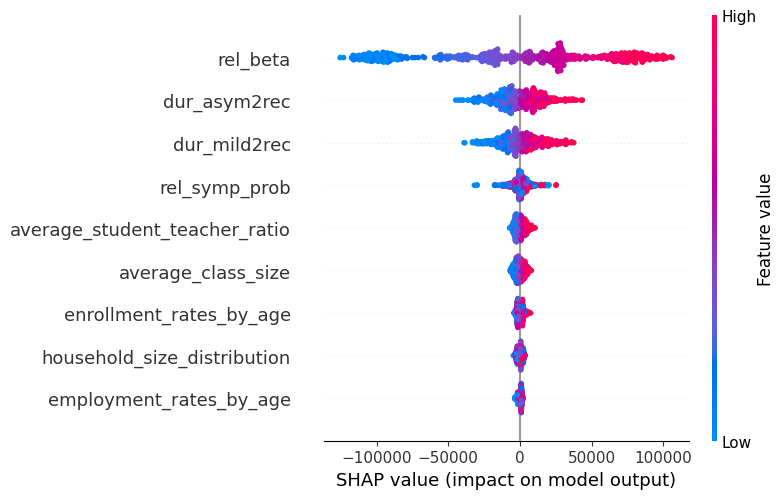

In [ ]:
#shap.summary_plot(shap_values, X_test_factor)

In [3]:
#Image(filename='conclusions.jpg')